# UAV Trajectory Planner
The problem of trajectory planning of a standard quadrotor Unmanned Aerial Vehicle is solved in this notebook. The UAV is considered with flat dynamics and supplemented with nonlinear battery model. Acceleration is considered as the control input of the UAV.

Further, the solution is sought using well-known open source Nonlinear Program (NLP) solver [Interior Point OPTimizer (IPOPT)](https://github.com/coin-or/Ipopt).



## Further implementation details
To interface [IPOPT](https://github.com/coin-or/Ipopt), which is C++ based toolbox, the Python package [pyomo](https://pyomo.readthedocs.io/), which is Pyhon-based open-source optimization modeling language, is employed.

The continuous linear dynamics of UAV is approximated with high-order pseudospectral polynomial using functions reimplemented from MATLAB code presented in [2]. 

In [1]:
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
import tikzplotlib as tplt
#import numpy.polynomial.chebyshev as cheb
#import cvxpy as cp
from pyomo.environ import *
import random

## 3D Gridmap with Obstacles

3D gridmap with obstacles defined as quadratic constraints. It can be incorporated into the NLP with quadratic constraints as inequality. Obstacles are sampled randomly through the whole space with uniform distribution.

In [2]:
dim = 3
state_dim = 2
# size of map
x_min, x_max = -100, 100
y_min, y_max = -100, 100
z_min, z_max = 0, 100
N_samples = 10
space = 5  # length of the side of the obstacle.
world_grid = [(x, y, z) for x in range(x_min, x_max, space)
              for y in range(y_min, y_max, space)
              for z in range(z_min, z_max, space)]  # grid points
randomset = np.array(random.sample(world_grid, N_samples))

# left part of inequivality
#F_obstacles = np.tile(A=np.eye(dim, dtype=int), reps=[2 * N_samples, 1])
#F_obstacles = np.tile(A=np.eye(dim, dtype=int), reps=[2 * N_samples, 1])
F_obstacles = np.tile(A=np.vstack(
    (-np.eye(dim, dtype=int), np.eye(dim, dtype=int))),
                      reps=[N_samples, 1])
# right part of inequivality
randomset_plus = randomset + space
randomset.shape
g_obstacles = np.concatenate((-randomset, randomset_plus), axis=1)
g_obstacles = g_obstacles.flatten()

# drone goal is on the ground
droneport_coordinates = np.array(random.sample(world_grid, 1))
droneport_coordinates[0, 2] = 1

# drone coordinates
drone = np.array(random.sample(world_grid, 1))
del (world_grid)

## Definition of Problem
Cost function of NLP is defined as follows:
$$J(x,u,t) = \int_{t_0}^{t_f} Q_r \left(\left(r_x(t)-r_{x,f}\right)^2+\left(r_y(t)-r_{y,f}\right)^2 +\left(r_z(t)-r_{z,f}\right)^2\right) + Q_v \left(v_x(t)^2 + v_y(t)^2 + v_z(t)^2\right) + Q_b\left(1-x_b(t)\right)^2 + R \left(a_x(t)^2 + a_y(t)^2 + a_z(t)^2\right) dt,$$
where control $u(t) = \left[a_x, a_y, a_z\right]^\mathsf{T}$ (desired acceleration) is weighted to keep the accelerations low and there is demand on the position $r(t)$ to get it close to the goal $r_{f}$ (location of DronePort platform). Further, the requirement to keep the capacity of battery high is stated.

The problem is further supplemented equality and inequality constraints for obstacles in form of norm
$-\|{r-c_i}\|_2 + R^2 \leq 0$, where $c_i$ is center of $i$-th obstacle and $R$ is a radius of obstacle
and UAV dynamics
$$\dot{x}_x(t) = A_x x_x(t) + B_x u_x(t),$$
$$\dot{x}_y(t) = A_y x_y(t) + B_y u_y(t),$$
$$\dot{x}_z(t) = A_z x_z(t) + B_z u_z(t),$$
where $x_x = \left[r_x,v_x\right]^\mathsf{T}$, $A_x = \begin{bmatrix}0 & 1 \\ 0 & 0\end{bmatrix}$, and $B_x = \left[0,1\right]^\mathsf{T}$ are state, matrices of dynamics and input for $x$-axis, respectively. Dynamics in $y$ and $z$ are defined analogically.

State of battery is described in standard manner using "state of charge" (SOC) which is given as 0.0 and 1.0 for empty full battery, respectively. The dynamics is described as
$$\dot{x}_b(t) = B_{b} \left(v_x^2 + v_y^2 + v_z^2\right) + D_b,$$
which includes linear discharging with time and also dependency on the square root of UAV velocity.

State of UAV is constrained by box constrains as
$$r_\min \leq r \leq r_\max, $$
$$v_\min \leq v \leq v_\max, $$
$$x_{b,\min} \leq x_b(t) \leq x_{b,\max}, $$
and control is constrained as
$$a_\min \leq a \leq a_\max. $$

Further, there the end of trajectory is constrained as
$$r(t_0) = r_0, v(t_0) = 0, x_b(t_0) = 1.0, u(t_0) = 0, t_0 = 0,$$
$$r(t_f) = r_f, v(t_f) = 0, u(t_f) = 0, 0 \leq t_f \leq 60.$$

In [3]:
# matrices of the model are the same for every axis
A = np.eye(2, k=1)  # state: position, speed, acceleration
B = np.array([0, 1])  # control: desired acceleration

Q = np.diag(np.array([5000, 800]))
Qr = Q[0, 0]
Qv = Q[1, 1]
R = np.array([[500]])

state_x_lim = np.array([x_min, -5, x_max, 5])
state_y_lim = np.array([y_min, -5, y_max, 5])
state_z_lim = np.array([z_min, -5, z_max, 5])
control_lim = np.array([-2, -2, -2, 2, 2, 2])
# change sign for right side of matrix inequality
state_x_lim[:np.int_(state_x_lim.size /
                     2)] = -state_x_lim[:np.int_(state_x_lim.size / 2)]
state_y_lim[:np.int_(state_y_lim.size /
                     2)] = -state_y_lim[:np.int_(state_y_lim.size / 2)]
state_z_lim[:np.int_(state_z_lim.size /
                     2)] = -state_z_lim[:np.int_(state_z_lim.size / 2)]
control_lim[:np.int_(control_lim.size /
                     2)] = -control_lim[:np.int_(control_lim.size / 2)]
# right side
F_dyn = np.vstack((-np.eye(state_dim, dtype=int), np.eye(state_dim,
                                                         dtype=int)))
F_ctrl = np.vstack((-np.eye(dim, dtype=int), np.eye(dim, dtype=int)))

In [4]:
batt_time = 30.0 * 60.0  # max time in air in seconds
batt_soc_max = 1.0  # maximum of battery capacity
batt_soc_min = 0.1  # minimum of battery capacity
A_b = 0.0  #1e-5 # battery life-time coefficient
B_b = -1e-4  # discharging with the square of speed
D_b = -1 / (batt_time)  # coefficient of discharging with time
Qb = 1e4

# Tools for Chebyshev polynomial approximation

All implemented methods are based or exactly rewritten from MATLAB implementation described in book [2].

In [5]:
def diff_matrix(N):
    """
    Calculate differentiation matrix for N-degree polynomial
    cheb.m, p. 54, from Trefethen, L. N. (2000). 
    Spectral Methods in MATLAB. In Spectral Methods in MATLAB. Society for Industrial and Applied Mathematics. https://doi.org/10.1137/1.9780898719598
    rewritten from Matlab to NumPy
    """

    #N = N - 1  # number of collocation points in degree of polynomial - 1
    x = np.sort(np.cos(np.pi * np.arange(N + 1) / N))
    c = np.ones(N + 1)
    c[0] = 2
    c[-1] = 2
    c = c * np.power((-1), np.arange(N + 1))
    X = np.matlib.repmat(x.reshape(x.shape[0], 1), 1, N + 1)
    dX = X - X.T
    D = (c.reshape(c.shape[0], 1) * (1 / c)) / (dX + (np.eye(N + 1)))
    D = D - np.diag(np.sum(D.T, 0))
    return D, x

In [6]:
def clencurt(N):
    """
    Calculate Clenshaw-Curtis integral weights for N-degree polynomial
    clencurt.m, p. 128, from Trefethen, L. N. (2000). 
    Spectral Methods in MATLAB. In Spectral Methods in MATLAB. Society for Industrial and Applied Mathematics. https://doi.org/10.1137/1.9780898719598
    rewritten from Matlab to NumPy
    """

    #N = N - 1  # number of collocation points is degree of polynomial - 1
    theta = (np.pi * np.arange(N + 1) / N)
    x = np.sort(np.cos(theta))
    theta = theta.reshape(theta.shape[0], 1)
    w = np.zeros((1, N + 1))
    ii = np.arange(1, N)
    v = np.ones((N - 1, 1))
    if np.mod(N, 2) == 0:
        w[0, 0] = 1 / (N * N - 1)
        w[0, -1] = w[0, 0]
        for k in np.arange(1, N / 2):
            v = v - 2 * np.cos(2 * k * theta[ii]) / (4 * k * k - 1)
        v = v - np.cos(N * theta[ii]) / (N * N - 1)
    else:
        w[0, 0] = 1 / (N * N)
        w[0, -1] = w[0, 0]
        for k in np.arange(1, (N - 1) / 2 + 1):
            v = v - 2 * np.cos(2 * k * theta[ii]) / (4 * k * k - 1)
    w[0, ii] = np.transpose(2 * v / N)
    return w[0], x

In [7]:
def cheb_scale(col, dom):
    """
    Rescaling of chebyshev points, weights and differential matrix to an arbitrary interval
    """

    shift = 0.5 * (dom[0] + dom[1])
    scale = 0.5 * (dom[1] - dom[0])

    x = scale * col[0] + shift
    w = col[1] * scale
    D = col[2] / scale

    return x, w, D

In [8]:
def cheb(N):
    """
    Calculate Gauss-Lobatto grid points, differentiation matrix and integral weights
    """

    D, xx = diff_matrix(N)
    ww, __ = clencurt(N)

    return xx, ww, D

## Transcription to NLP

In [9]:
N_col = 50  # (N-1)-th degree polynomial (with N collocation points)
col = cheb(N_col)  # t, w, D

model = ConcreteModel()
model.n = Param(initialize=N_col, within=PositiveIntegers)
model.N = Set(initialize=range(0, value(model.n) + 1))

model.D_N = col[2]
model.w_N = col[1]
model.minus1ti_N = col[0]

# initial point
# rx0 = drone[0, 0]
# ry0 = drone[0, 1]
# rz0 = drone[0, 2]
rx0 = -80.0
ry0 = -80.0
rz0 = 50.0
vx0 = 0.0
vy0 = 0.0
vz0 = 0.0
soc0 = 1.0

# end point
# rxf = droneport_coordinates[0, 0]
# ryf = droneport_coordinates[0, 1]
# rzf = droneport_coordinates[0, 2]
rxf = 80.0
ryf = 80.0
rzf = 1.0
vxf = 0.0
vyf = 0.0
vzf = 0.0
tf_min = 1.0
tf_max = 20.0 * 60.0
tf_max = 3 * 60.0

# path constraints
rx_min = -100.0
vx_min = -5.0
ax_min = -2.0
ry_min = -100.0
vy_min = -5.0
ay_min = -2.0
rz_min = -100.0
vz_min = -5.0
az_min = -2.0
soc_min = 0.1
rx_max = 100.0
vx_max = 5.0
ax_max = 2.0
ry_max = 100.0
vy_max = 5.0
ay_max = 2.0
rz_max = 100.0
vz_max = 5.0
az_max = 2.0
soc_max = 1.0

model.initial_time = Param(initialize=0.0)

final_time_approx = 0.5 * tf_max
model.final_time = Var(domain=NonNegativeReals,
                       bounds=(tf_min, tf_max),
                       initialize=final_time_approx)

# init of variables with boundaries
model.rx = Var(model.N, within=Reals, bounds=(rx_min, rx_max), initialize=rx0)
model.ry = Var(model.N, within=Reals, bounds=(ry_min, ry_max), initialize=rx0)
model.rz = Var(model.N, within=Reals, bounds=(rz_min, rz_max), initialize=rz0)
model.vx = Var(model.N, within=Reals, bounds=(vx_min, vx_max), initialize=vx0)
model.vy = Var(model.N, within=Reals, bounds=(vy_min, vy_max), initialize=vy0)
model.vz = Var(model.N, within=Reals, bounds=(vz_min, vz_max), initialize=vz0)
model.soc = Var(model.N,
                within=Reals,
                bounds=(soc_min, soc_max),
                initialize=soc0)
model.ax = Var(model.N, domain=Reals, bounds=(ax_min, ax_max), initialize=0.0)
model.ay = Var(model.N, domain=Reals, bounds=(ay_min, ay_max), initialize=0.0)
model.az = Var(model.N, domain=Reals, bounds=(az_min, az_max), initialize=0.0)

# model.rx = Var(model.N, within=Reals,  initialize=rx0)
# model.ry = Var(model.N, within=Reals,  initialize=ry0)
# model.rz = Var(model.N, within=Reals,  initialize=rz0)
# model.vx = Var(model.N, within=Reals,  initialize=vx0)
# model.vy = Var(model.N, within=Reals,  initialize=vy0)
# model.vz = Var(model.N, within=Reals,  initialize=vz0)
# model.soc = Var(model.N, within=Reals, bounds=(soc_min, soc_max), initialize=soc0)
# model.ax = Var(model.N, domain=Reals, bounds=(ax_min, ax_max), initialize=0.0)
# model.ay = Var(model.N, domain=Reals, bounds=(ay_min, ay_max), initialize=0.0)
# model.az = Var(model.N, domain=Reals, bounds=(az_min, az_max), initialize=0.0)

# variables for dynamics
model.f_rx = Var(model.N, domain=Reals)
model.f_vx = Var(model.N, domain=Reals)
model.f_ry = Var(model.N, domain=Reals)
model.f_vy = Var(model.N, domain=Reals)
model.f_rz = Var(model.N, domain=Reals)
model.f_vz = Var(model.N, domain=Reals)
model.f_soc = Var(model.N, domain=Reals)

# set initial conditions
model.rx_initial_constA = Constraint(rule=model.rx[0] == rx0)
model.ry_initial_constA = Constraint(rule=model.ry[0] == ry0)
model.rz_initial_constA = Constraint(rule=model.rz[0] == rz0)
model.vx_initial_constA = Constraint(rule=model.vx[0] == vx0)
model.vy_initial_constA = Constraint(rule=model.vy[0] == vy0)
model.vz_initial_constA = Constraint(rule=model.vz[0] == vz0)
model.soc_initial_constA = Constraint(rule=model.soc[0] == soc0)

# set terminal conditions
model.rx_final_constA = Constraint(rule=model.rx[N_col] == rxf)
model.ry_final_constA = Constraint(rule=model.ry[N_col] == ryf)
model.rz_final_constA = Constraint(rule=model.rz[N_col] == rzf)
model.vx_final_constA = Constraint(rule=model.vx[N_col] == vxf)
model.vy_final_constA = Constraint(rule=model.vy[N_col] == vyf)
model.vz_final_constA = Constraint(rule=model.vz[N_col] == vzf)


# dynamics functions
def f_rx_definition(model, i):
    return model.f_rx[i] == model.vx[i]


model.f_rx_const = Constraint(model.N, rule=f_rx_definition)


def f_ry_definition(model, i):
    return model.f_ry[i] == model.vy[i]


model.f_ry_const = Constraint(model.N, rule=f_ry_definition)


def f_rz_definition(model, i):
    return model.f_rz[i] == model.vz[i]


model.f_rz_const = Constraint(model.N, rule=f_rz_definition)


def f_vx_definition(model, i):
    return model.f_vx[i] == model.ax[i]


model.f_vx_const = Constraint(model.N, rule=f_vx_definition)


def f_vy_definition(model, i):
    return model.f_vy[i] == model.ay[i]


model.f_vy_const = Constraint(model.N, rule=f_vy_definition)


def f_vz_definition(model, i):
    return model.f_vz[i] == model.az[i]


model.f_vz_const = Constraint(model.N, rule=f_vz_definition)


def f_soc_definition(model, i):
    return model.f_soc[i] == A_b * model.soc[i] + B_b * (
        model.vx[i]**2 + model.vy[i]**2 + model.vz[i]**2) + D_b


model.f_soc_const = Constraint(model.N, rule=f_soc_definition)

model.time = Var(model.N, domain=Reals)


# time constraint
def time_definition1_N(model, i):
    return model.time[i] == (
        (model.final_time - model.initial_time) * model.minus1ti_N[i] +
        (model.final_time + model.initial_time)) / 2


model.time_definition1_const_N = Constraint(model.N, rule=time_definition1_N)


# dynamics constraints
def rx_PSChebyshev_eqA_N(model, i):
    return 0.0 == (
        (model.final_time - model.initial_time) / 2) * (model.f_rx[i]) - sum(
            model.rx[k] * model.D_N[i, k] for k in model.N)


model.rx_PSChebyshev_eqA_N_const = Constraint(model.N,
                                              rule=rx_PSChebyshev_eqA_N)


def ry_PSChebyshev_eqA_N(model, i):
    return 0.0 == (
        (model.final_time - model.initial_time) / 2) * (model.f_ry[i]) - sum(
            model.ry[k] * model.D_N[i, k] for k in model.N)


model.ry_PSChebyshev_eqA_N_const = Constraint(model.N,
                                              rule=ry_PSChebyshev_eqA_N)


def rz_PSChebyshev_eqA_N(model, i):
    return 0.0 == (
        (model.final_time - model.initial_time) / 2) * (model.f_rz[i]) - sum(
            model.rz[k] * model.D_N[i, k] for k in model.N)


model.rz_PSChebyshev_eqA_N_const = Constraint(model.N,
                                              rule=rz_PSChebyshev_eqA_N)


def vx_PSChebyshev_eqA_N(model, i):
    return 0.0 == (
        (model.final_time - model.initial_time) / 2) * (model.f_vx[i]) - sum(
            model.vx[k] * model.D_N[i, k] for k in model.N)


model.vx_PSChebyshev_eqA_N_const = Constraint(model.N,
                                              rule=vx_PSChebyshev_eqA_N)


def vy_PSChebyshev_eqA_N(model, i):
    return 0.0 == (
        (model.final_time - model.initial_time) / 2) * (model.f_vy[i]) - sum(
            model.vy[k] * model.D_N[i, k] for k in model.N)


model.vy_PSChebyshev_eqA_N_const = Constraint(model.N,
                                              rule=vy_PSChebyshev_eqA_N)


def vz_PSChebyshev_eqA_N(model, i):
    return 0.0 == (
        (model.final_time - model.initial_time) / 2) * (model.f_vz[i]) - sum(
            model.vz[k] * model.D_N[i, k] for k in model.N)


model.vz_PSChebyshev_eqA_N_const = Constraint(model.N,
                                              rule=vz_PSChebyshev_eqA_N)


def soc_PSChebyshev_eqA_N(model, i):
    return 0.0 == (
        (model.final_time - model.initial_time) / 2) * (model.f_soc[i]) - sum(
            model.soc[k] * model.D_N[i, k] for k in model.N)


model.soc_PSChebyshev_eqA_N_const = Constraint(model.N,
                                               rule=soc_PSChebyshev_eqA_N)

# model.obj = Objective(expr=sum(
#     (((model.final_time - model.initial_time) * 0.5) * model.w_N[i] *
#      (Qr * ((model.rx[i] - rxf)**2 + (model.ry[i] - ryf)**2 +
#             (model.rz[i] - rzf)**2) + Qv *
#       (model.vx[i]**2 + model.vy[i]**2 + model.vz[i]**2) + Qb *
#       ((1 - model.soc[i])**2) + R[0, 0] *
#       (model.ax[i]**2 + model.ay[i]**2 + model.az[i]**2))) for i in model.N),
#                       sense=minimize)

model.obj = Objective(expr=sum(
    (((model.final_time - model.initial_time) * 0.5) * model.w_N[i] *
     (Qb * ((1 - model.soc[i])**2)))
    for i in model.N),
                      sense=minimize)

# model.obj = Objective(expr=sum(model.w_N[i]*Qr * ((model.rx[i] - rxf)**2 + (model.ry[i] - ryf)**2 +
#              (model.rz[i] - rzf)**2)for i in model.N), sense=minimize)

# model.obj = Objective(expr=model.final_time, sense=minimize)


def limit_obstacles(model, i):
    return -sqrt((model.rx[i] - randomset[j, 0])**2 +
                 (model.ry[i] - randomset[j, 1])**2 +
                 (model.rz[i] - randomset[j, 2])**2) + space**2 <= 0


model.limit_obstacles = ConstraintList()
for i in model.N:
    for j in range(randomset.shape[0]):
        model.limit_obstacles.add(
            -sqrt((model.rx[i] - randomset[j, 0])**2 +
                  (model.ry[i] - randomset[j, 1])**2 +
                  (model.rz[i] - randomset[j, 2])**2) + space**2 <= 0)

In [10]:
# Create the ipopt solver plugin using the ASL interface
solver = 'ipopt'
solver_io = 'nl'
stream_solver = True  # True prints solver output to screen
keepfiles = True  # True prints intermediate file names (.nl,.sol,...)
opt = SolverFactory(solver, solver_io=solver_io)

if opt is None:
    print("")
    print("ERROR: Unable to create solver plugin for %s "\
          "using the %s interface" % (solver, solver_io))
    print("")
    exit(1)

### Declare all suffixes
# Ipopt bound multipliers (obtained from solution)
model.ipopt_zL_out = Suffix(direction=Suffix.IMPORT)
model.ipopt_zU_out = Suffix(direction=Suffix.IMPORT)

# Ipopt bound multipliers (sent to solver)
model.ipopt_zL_in = Suffix(direction=Suffix.EXPORT)
model.ipopt_zU_in = Suffix(direction=Suffix.EXPORT)

# Obtain dual solutions from first solve and send to warm start
model.dual = Suffix(direction=Suffix.IMPORT_EXPORT)

### Generate the constraint expression trees if necessary
if solver_io != 'nl':
    # only required when not using the ASL interface
    model.preprocess()

### Send the model to ipopt and collect the solution
print("")
print("INITIAL SOLVE")
## Set the max number of iterations
opt.options['max_iter'] = 1000
#opt.options['tol'] = 1e-3
results = opt.solve(model, keepfiles=keepfiles, tee=stream_solver)
# load the results (including any values for previously declared
# IMPORT / IMPORT_EXPORT Suffix components)
#model.solutions.load_from(results)
#model.load(results)

### Set Ipopt options for warm-start
# The current values on the ipopt_zU_out and ipopt_zL_out suffixes will be used as initial
# conditions for the bound multipliers to solve the new problem
model.ipopt_zL_in.update(model.ipopt_zL_out)
model.ipopt_zU_in.update(model.ipopt_zU_out)
opt.options['warm_start_init_point'] = 'yes'
opt.options['halt_on_ampl_error'] = 'yes'

#opt.options['warm_start_bound_push'] = 1e-6
#opt.options['warm_start_mult_bound_push'] = 1e-6
#opt.options['tol'] = 1e-6
#opt.options['mu_init'] = 1e-6

#######################################################################################
### Send the model and suffix information to ipopt and collect the solution
print("")
print("WARM-STARTED SOLVE")
## Set the max number of iterations
opt.options[
    'max_iter'] = 1000  # The solver plugin will scan the model for all active suffixes
# valid for importing, which it will store into the results object
results = opt.solve(model, keepfiles=keepfiles, tee=stream_solver)
# load the results (including any values for previously declared
# IMPORT / IMPORT_EXPORT Suffix components)
model.solutions.load_from(results)


INITIAL SOLVE
Solver log file: '/tmp/tmp6l3jdhg6_ipopt.log'
Solver solution file: '/tmp/tmpdeod11gh.pyomo.sol'
Solver problem files: ('/tmp/tmpdeod11gh.pyomo.nl',)
Ipopt 3.13.4: max_iter=1000
ERROR: Output stream closed before all output was written to it. The following
    was left in the output buffer:
    	'Ipopt 3.13.4: max_iter=1000\n'


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:    19851
Number of nonzeros in inequality constraint Jacobian.:     15

  22  3.9885614e+03 1.35e+02 1.44e+03  -1.0 1.77e+03    -  4.62e-04 1.85e-04h  1
ERROR: Output stream closed before all output was written to it. The following
    was left in the output buffer:
    	'  22  3.9885614e+03 1.35e+02 1.44e+03  -1.0 1.77e+03    -  4.62e-04
    	1.85e-04h  1\n'
  23  4.0463556e+03 1.35e+02 1.44e+03  -1.0 2.16e+03    -  1.87e-04 1.02e-03h  1
ERROR: Output stream closed before all output was written to it. The following
    was left in the output buffer:
    	'  23  4.0463556e+03 1.35e+02 1.44e+03  -1.0 2.16e+03    -  1.87e-04
    	1.02e-03h  1\n'
  24  4.0558806e+03 1.35e+02 1.44e+03  -1.0 2.40e+03    -  6.17e-04 1.23e-04h  1
ERROR: Output stream closed before all output was written to it. The following
    was left in the output buffer:
    	'  24  4.0558806e+03 1.35e+02 1.44e+03  -1.0 2.40e+03    -  6.17e-04
    	1.23e-04h  1\n'
  25  4.1367710e+03 1.34e+02 1.43e+03  -1.0 2.35e+03    -  1.39e-03 9.69e-04h  1
ERROR: Output stream closed before all output was

  52  1.1387629e+04 1.14e+02 2.91e+03  -1.0 1.61e+02    -  5.50e-05 6.17e-03h  1
ERROR: Output stream closed before all output was written to it. The following
    was left in the output buffer:
    	'  52  1.1387629e+04 1.14e+02 2.91e+03  -1.0 1.61e+02    -  5.50e-05
    	6.17e-03h  1\n'
  53  1.1387933e+04 1.14e+02 2.91e+03  -1.0 1.55e+02    -  3.03e-03 2.56e-04h  1
ERROR: Output stream closed before all output was written to it. The following
    was left in the output buffer:
    	'  53  1.1387933e+04 1.14e+02 2.91e+03  -1.0 1.55e+02    -  3.03e-03
    	2.56e-04h  1\n'
  54  1.1391043e+04 1.13e+02 2.90e+03  -1.0 1.55e+02    -  5.45e-04 4.99e-03h  1
ERROR: Output stream closed before all output was written to it. The following
    was left in the output buffer:
    	'  54  1.1391043e+04 1.13e+02 2.90e+03  -1.0 1.55e+02    -  5.45e-04
    	4.99e-03h  1\n'
  55  1.1391247e+04 1.13e+02 2.89e+03  -1.0 1.54e+02    -  9.51e-03 1.19e-04h  1
ERROR: Output stream closed before all output was

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80  1.1640123e+04 8.26e+01 2.10e+03  -1.0 1.21e+02    -  5.59e-02 4.33e-02h  2
ERROR: Output stream closed before all output was written to it. The following
    was left in the output buffer:
    	'iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du
    	alpha_pr  ls\n  80  1.1640123e+04 8.26e+01 2.10e+03  -1.0 1.21e+02    -
    	5.59e-02 4.33e-02h  2\n'
  81  1.1709768e+04 8.01e+01 2.04e+03  -1.0 1.16e+02    -  4.09e-02 3.09e-02h  2
ERROR: Output stream closed before all output was written to it. The following
    was left in the output buffer:
    	'  81  1.1709768e+04 8.01e+01 2.04e+03  -1.0 1.16e+02    -  4.09e-02
    	3.09e-02h  2\n'
  82  1.1786060e+04 7.75e+01 1.97e+03  -1.0 1.13e+02    -  4.26e-02 3.24e-02h  1
ERROR: Output stream closed before all output was written to it. The following
    was left in the output buffer:
    	'  82  1.1786060e+04 7.75e+01 1.97e+03  -1.0 1.13e+02

 123  1.2579344e+05 4.22e+00 2.54e+04  -1.0 1.94e+02    -  3.81e-03 2.46e-03f  1
ERROR: Output stream closed before all output was written to it. The following
    was left in the output buffer:
    	' 123  1.2579344e+05 4.22e+00 2.54e+04  -1.0 1.94e+02    -  3.81e-03
    	2.46e-03f  1\n'
 124  1.1843745e+05 4.10e+00 2.43e+04  -1.0 1.29e+02    -  7.65e-03 4.19e-02f  1
ERROR: Output stream closed before all output was written to it. The following
    was left in the output buffer:
    	' 124  1.1843745e+05 4.10e+00 2.43e+04  -1.0 1.29e+02    -  7.65e-03
    	4.19e-02f  1\n'
 125  1.1121964e+05 3.95e+00 2.32e+04  -1.0 4.35e+01    -  1.69e-02 4.41e-02f  1
ERROR: Output stream closed before all output was written to it. The following
    was left in the output buffer:
    	' 125  1.1121964e+05 3.95e+00 2.32e+04  -1.0 4.35e+01    -  1.69e-02
    	4.41e-02f  1\n'
 126  1.0558249e+05 3.83e+00 2.24e+04  -1.0 1.96e+01    -  6.30e-02 3.71e-02f  1
ERROR: Output stream closed before all output was

 151  2.5716295e+03 1.09e-02 4.88e+04  -3.8 5.12e-01    -  9.11e-01 9.48e-01h  1
ERROR: Output stream closed before all output was written to it. The following
    was left in the output buffer:
    	' 151  2.5716295e+03 1.09e-02 4.88e+04  -3.8 5.12e-01    -  9.11e-01
    	9.48e-01h  1\n'
 152  2.5716021e+03 1.20e-03 2.19e-03  -3.8 3.06e-01    -  1.00e+00 1.00e+00h  1
ERROR: Output stream closed before all output was written to it. The following
    was left in the output buffer:
    	' 152  2.5716021e+03 1.20e-03 2.19e-03  -3.8 3.06e-01    -  1.00e+00
    	1.00e+00h  1\n'
 153  2.5716020e+03 6.52e-05 8.02e-05  -3.8 1.12e-01    -  1.00e+00 1.00e+00h  1
ERROR: Output stream closed before all output was written to it. The following
    was left in the output buffer:
    	' 153  2.5716020e+03 6.52e-05 8.02e-05  -3.8 1.12e-01    -  1.00e+00
    	1.00e+00h  1\n'
 154  2.5715950e+03 5.94e-06 1.52e-05  -5.7 1.44e-02    -  1.00e+00 1.00e+00h  1
ERROR: Output stream closed before all output was

   2  2.6578241e+03 4.48e+00 6.25e+00  -1.0 1.13e+01    -  3.63e-01 6.31e-01f  1
ERROR: Output stream closed before all output was written to it. The following
    was left in the output buffer:
    	'   2  2.6578241e+03 4.48e+00 6.25e+00  -1.0 1.13e+01    -  3.63e-01
    	6.31e-01f  1\n'
   3  2.7028131e+03 2.53e+00 5.15e+00  -1.0 1.66e+01    -  3.88e-01 5.18e-01H  1
ERROR: Output stream closed before all output was written to it. The following
    was left in the output buffer:
    	'   3  2.7028131e+03 2.53e+00 5.15e+00  -1.0 1.66e+01    -  3.88e-01
    	5.18e-01H  1\n'
   4  2.7427325e+03 6.10e+00 2.27e+01  -1.0 6.52e+01  -4.0 8.68e-02 3.88e-01f  1
ERROR: Output stream closed before all output was written to it. The following
    was left in the output buffer:
    	'   4  2.7427325e+03 6.10e+00 2.27e+01  -1.0 6.52e+01  -4.0 8.68e-02
    	3.88e-01f  1\n'
   5  2.6661806e+03 5.28e+00 2.12e+01  -1.0 2.79e+02    -  7.42e-02 7.65e-02f  1
ERROR: Output stream closed before all output was

/home/zboucek/anaconda3/envs/svk21/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/zboucek/anaconda3/envs/svk21/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/zboucek/anaconda3/envs/svk21/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)

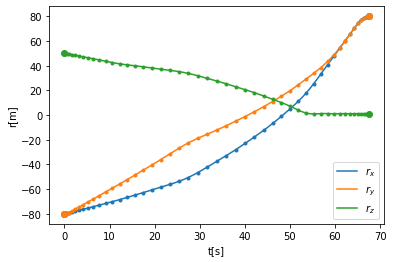

In [46]:
time = np.zeros(len(model.time))
rx = np.zeros(len(model.rx))
ry = np.zeros(len(model.ry))
rz = np.zeros(len(model.rz))
for i in model.time:
    time[i] = model.time[i].value
for i in model.rx:
    rx[i] = model.rx[i].value
for i in model.ry:
    ry[i] = model.ry[i].value
for i in model.rz:
    rz[i] = model.rz[i].value

time_poly = np.arange(time[0], time[-1], 0.01)
rx_poly = np.polyval(np.polyfit(time, rx, N_col), time_poly)
ry_poly = np.polyval(np.polyfit(time, ry, N_col), time_poly)
rz_poly = np.polyval(np.polyfit(time, rz, N_col), time_poly)
plt.plot(time_poly, rx_poly)
plt.plot(time_poly, ry_poly)
plt.plot(time_poly, rz_poly)
plt.gca().set_prop_cycle(None)
plt.plot(time, rx, '.')
plt.plot(time, ry, '.')
plt.plot(time, rz, '.')
plt.gca().set_prop_cycle(None)
plt.plot(0, rx0, 'o')
plt.plot(0, ry0, 'o')
plt.plot(0, rz0, 'o')
plt.gca().set_prop_cycle(None)
plt.plot(time[-1], rxf, 'o')
plt.plot(time[-1], ryf, 'o')
plt.plot(time[-1], rzf, 'o')
plt.xlabel('t[s]')
plt.ylabel('r[m]')
plt.legend([
    '$r_x$',
    '$r_y$',
    '$r_z$',
])
plt.savefig('tex/position.eps')
tplt.clean_figure()
tplt.save('tex/position.tex')
print([rx0, ry0, rz0])
print([rxf, ryf, rzf])

/home/zboucek/anaconda3/envs/svk21/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/zboucek/anaconda3/envs/svk21/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/zboucek/anaconda3/envs/svk21/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


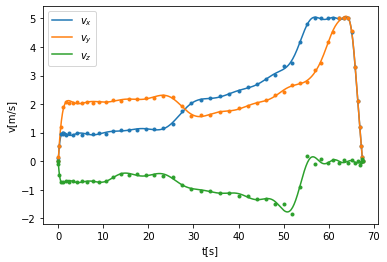

In [45]:
vx = np.zeros(len(model.vx))
vy = np.zeros(len(model.vy))
vz = np.zeros(len(model.vz))
for i in model.vx:
    vx[i] = model.vx[i].value
for i in model.vy:
    vy[i] = model.vy[i].value
for i in model.vz:
    vz[i] = model.vz[i].value

time_poly = np.arange(time[0], time[-1], 0.01)
vx_poly = np.polyval(np.polyfit(time, vx, N_col -1), time_poly)
vy_poly = np.polyval(np.polyfit(time, vy, N_col -1), time_poly)
vz_poly = np.polyval(np.polyfit(time, vz, N_col -1), time_poly)
plt.plot(time_poly, vx_poly)
plt.plot(time_poly, vy_poly)
plt.plot(time_poly, vz_poly)
plt.gca().set_prop_cycle(None)
plt.plot(time, vx, '.')
plt.plot(time, vy, '.')
plt.plot(time, vz, '.')
plt.xlabel('t[s]')
plt.ylabel('v[m/s]')
plt.legend(['$v_x$', '$v_y$', '$v_z$'])
plt.savefig('tex/velocity.eps')
tplt.clean_figure()
tplt.save('tex/velocity.tex')

/home/zboucek/anaconda3/envs/svk21/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/zboucek/anaconda3/envs/svk21/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/zboucek/anaconda3/envs/svk21/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


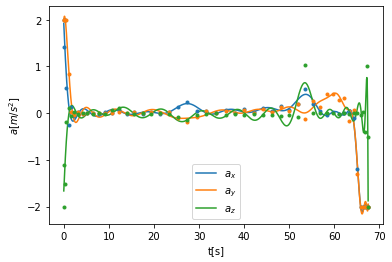

In [44]:
ax = np.zeros(len(model.ax))
ay = np.zeros(len(model.ay))
az = np.zeros(len(model.az))
for i in model.ax:
    ax[i] = model.ax[i].value
for i in model.ay:
    ay[i] = model.ay[i].value
for i in model.az:
    az[i] = model.az[i].value

time_poly = np.arange(time[0], time[-1], 0.01)
ax_poly = np.polyval(np.polyfit(time, ax, N_col-1), time_poly)
ay_poly = np.polyval(np.polyfit(time, ay, N_col-1), time_poly)
az_poly = np.polyval(np.polyfit(time, az, N_col-1), time_poly)
plt.plot(time_poly, ax_poly)
plt.plot(time_poly, ay_poly)
plt.plot(time_poly, az_poly)
plt.gca().set_prop_cycle(None)
plt.plot(time, ax, '.')
plt.plot(time, ay, '.')
plt.plot(time, az, '.')
plt.xlabel('t[s]')
plt.ylabel('$a[m/s^2]$')
plt.legend(['$a_x$', '$a_y$', '$a_z$'])
plt.savefig('tex/acceleration.eps')
tplt.clean_figure()
tplt.save('tex/acceleration.tex')

/home/zboucek/anaconda3/envs/svk21/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


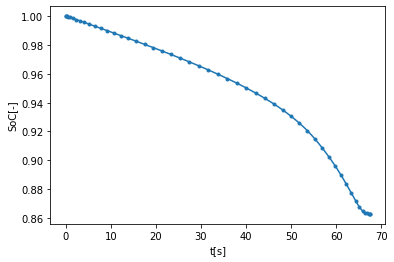

In [42]:
soc = np.zeros(len(model.soc))
#uu = np.polyval(np.polyfit(t,pos[0,:].value,N_col+1),t)
for i in model.soc:
    soc[i] = model.soc[i].value

time_poly = np.arange(time[0], time[-1], 0.01)
soc_poly = np.polyval(np.polyfit(time, soc, N_col-2), time_poly)
plt.plot(time_poly, soc_poly)
plt.gca().set_prop_cycle(None)
plt.plot(time, soc, '.')
plt.xlabel('t[s]')
plt.ylabel('SoC[-]')
plt.savefig('tex/state-of-charge.eps')
tplt.clean_figure()
tplt.save('tex/state-of-charge.tex')

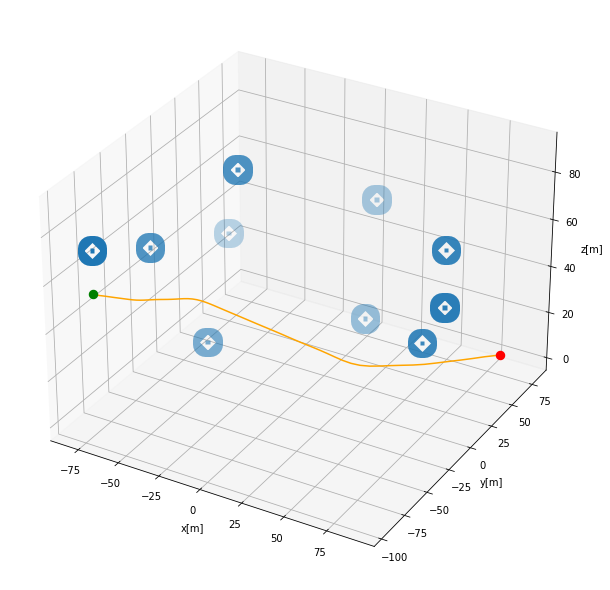

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

In [80]:
fig = plt.figure()
ax = plt.axes(projection="3d")
#plt.title('3D grid map')
fig.set_figwidth(8)
fig.set_figheight(8)
ax.scatter3D(randomset[:, 0],
             randomset[:, 1],
             randomset[:, 2],
             marker='s',
             linewidths=space**2)
ax.set_xlabel("x[m]")
ax.set_ylabel("y[m]")
ax.set_zlabel("z[m]")
ax.scatter3D(rx0,
             ry0,
             rz0,
             marker='o',
             linewidths=space,
             color='green')
ax.scatter3D(rxf,
             ryf,
             rzf,
             marker='o',
             linewidths=space,
             color='red')
ax.plot3D(rx_poly[0:-1:100],
          ry_poly[0:-1:100],
          rz_poly[0:-1:100],
          color='orange')
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
plt.show()
fig.savefig('tex/3d-position.eps')
# 
# 3D plots DO NOT WORK in tikzplotlib!!!
#
#tplt.clean_figure()
#tplt.save('tex/3d-position.tex')

In [16]:
with open('psm_out.npy', 'wb') as f:
    np.savez(f,
             rx=rx,
             ry=ry,
             rz=rz,
             vx=vx,
             vy=vy,
             vz=vz,
             ax=ax,
             ay=ay,
             az=az,
             soc=soc,
             time=time)

# Bibliography

[1] [Zhang, D., Dey, S., Perez, H. E., & Moura, S. J. (2020). Real-time capacity estimation of lithium-ion batteries utilizing thermal dynamics. IEEE Transactions on Control Systems Technology, 28(3), 992–1000.](https://doi.org/10.1109/TCST.2018.2885681)

[2] [Trefethen, L. N. (2000). 
    Spectral Methods in MATLAB. In Spectral Methods in MATLAB. Society for Industrial and Applied Mathematics.](https://doi.org/10.1137/1.9780898719598)

# Troubles with problem

While solving the trajectory planning problem, several problems occurred. Further, some of these problems are discussed with possible solution.

## Battery
Model of battery is problematic because it is dependent on the time of flight and norm of UAV speed/acceleration. Thus, it is nonlinear. Moreover, it could be challenging to identify/set parameters of the model. Also, a long-term properties of the battery could be included.

## Obstacles
Usually, obstacles are incorporated in the problem [as constraints](https://groups.google.com/g/yalmip/c/xMJy9JWiYDs). Nevertheless, the problem arises, because in standard manner they are in form of norm: $-\|{x-c}\|_a + R^2 \leq 0$, where $a = \infty$ or $a = 2$, $c$ is center of obstacle and $R$ is a radius. 

Some solvers are able to translate this constraint into MIQP/MINLP (mixed-integer quadratic/nonlinear programming), however, it is not the case with CVXPY (even if used solver GUROBI is able to do this). Thus, the solution would be to incorporate the integer variables manually or employ some other wrapper. 

Due to other problems it could be beneficial to use PSM NLP such as OpenGoddard. The only weakness of OpenGoddard is, that it uses SciPy for solution, which is compared to e.g. IPOPT slow. PSOPT uses IPOPT, but it cannot be easily interfaced due to its strict implementation in C++ and necessity of implementation of dynamic equation as C++ code.

## Solution without obstacles

It seems that grid points of PSM aren't linked properly with differential matrix, because the solution is rather discontinuous and does not hold the physical properties which arises from the model. 

## Time as variable

In this case, the time was originally intended as variable, at least its endpoint $t_f$. Nevertheless, the differential matrix must be scaled according to chosen time span and it makes the approximation of derivative nonlinear (multiplied by end point time).

## Wrong dimension

The acceleration is **not** part of state, but the control input. It do not have to be included in continuous-time model opposed to discrete-time model.

# Old

## Battery model stuff
Further, the battery is described as
$$\dot{x}_b(t) = A_b x_b(t) + B_b u_b(t)$$

Battery dynamics model is taken from [1], nevertheless, only the electrical part without thermal model is employed for simplicity 
$$\dot{SOC}(t) = -\frac{I(t)}{C_{b}},$$
where $SOC$ is "state of charge" which is given percentage points (0% = empty; 100% = full), $I(t)$ is (dis)charging current (negative for discharging) and $C_b$ is battery capacity in Ampere-seconds.
Simple battery model:
$$\dot{x}_b(t) = A_b x_b(t) + B_{b} v^2(t) + D_b$$

In [17]:
# batt_time = 30 * 60  # max time in air in seconds
# batt_soc_max = 1.0  # maximum of battery capacity
# batt_soc_min = 0.1  # minimum of battery capacity
# B_b = 0.1  # discharging with the square of speed
# D_b = -1 / (batt_time)  # coefficient of discharging with time
# A_b = 0  # could describe batteries long term properties (how fast it is discharging)

## NLP solver employment

Further, the solution is sought using well-known open source Nonlinear Program (NLP) solver [Interior Point OPTimizer (IPOPT)](https://github.com/coin-or/Ipopt).

To interface [IPOPT](https://github.com/coin-or/Ipopt), which is C++ based toolbox, the Python wrapper [cyipopt](https://github.com/mechmotum/cyipopt) is employed.

## Cheby stuff

In [18]:
# # intergral weights for Legendre collocation points
# beta = 0.5 / np.sqrt(1 - np.power(2 * np.arange(1, N), -2.0))
# T = np.diag(beta, 1) + np.diag(beta, -1)
# [D, V] = np.linalg.eig(T)
# x = np.sort(D)
# w = 2 * np.power(V[0, :], 2)
# print(w)

In [19]:
# # sth with cheby polynomials in numpy
# w = cheb.chebgauss(10)
# poly = cheb.Chebyshev.basis(10, ([-1, 1]))
# poly.deriv(1)
# #print(cheb.Chebyshev.roots)

library with polynomials such as Chebyshev or Legendre with various roots and integral weights

In [20]:
# from scipy import special